In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf

In [3]:
import warnings
warnings.filterwarnings('ignore')
from tensorflow.python.keras.applications import DenseNet169


In [4]:
# model = ResNet50(include_top=True, weights=None, input_shape=(224, 224, 3), pooling=max, classes=7)
from tensorflow.python.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.python.keras.models import Model

backbone = DenseNet169(include_top=False, weights=None, input_shape=(224, 224, 3))
backbone_out = backbone.output
gap = GlobalAveragePooling2D(name='pooling_layer')(backbone_out)
output = Dense(units=7, activation='softmax', name='output_layer')(gap)
chexnet_model = Model(inputs=backbone.input, outputs=output)

Instructions for updating:
Colocations handled automatically by placer.


In [4]:
# model.summary()

In [5]:
import pandas as pd

# data = pd.read_csv('./dataset.csv',index_col=0)
data = pd.read_csv('/home/ncp/workspace/data/dataset_.csv',index_col=0)

In [6]:
data.head(1)

,identifier,sex,age_group,age,height,weight,report,pneumonia_type,orginal_dcm_file,orginal_png_file,crop_file,body_part_file,diagnosis
0,H05_00019_02,M,A1,0개월,NaN,0.9,NaN,NaN,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,/home/ncp/workspace/data/crop/d4/H05_00019_02.png,/home/ncp/workspace/data/train/04.신생아호흡곤란증후군/A...,4


In [6]:
crop_list = list(data['crop_file'])

In [7]:
import cv2
import matplotlib.pyplot as plt

# plt.imshow(cv2.imread(crop_list[0]))
# print(cv2.imread(crop_list[0]).shape)

In [8]:
import numpy as np
import cv2

def cvt_crop(og_img_path, size):
    
    og_img = cv2.imread(og_img_path)
    
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(20,20))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)
    cvt_img = cvt_img

    return cvt_img
#     print(remove.shape)
#     plt.imshow(remove)

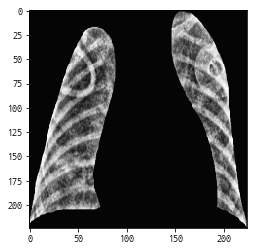

In [72]:
plt.imshow(cvt_crop(crop_list[0], (224,224)))

In [9]:
def normal_dia(x):
    if x == 9:
        return 0
    else:
        return x
    
    
data['diagnosis'] = data['diagnosis'].apply(normal_dia)

In [11]:
len(data)

4000

In [13]:
dcm_list = list(data['orginal_dcm_file'])
mask_path_list = list(data['body_part_file'])
img_path_list = []

for i in dcm_list:
    png_img = i.replace('.dcm','.png')
    img_path_list.append(png_img)

In [ ]:
import numpy as np

def rv_3ch(og_img_path, mask_path, size):
    
    #module import
    import cv2
    
    # im_read
    og_img = cv2.imread(og_img_path)
    mask = cv2.imread(mask_path)
    
    # clahe
    clahe = cv2.createCLAHE(5.0,(8,8))
    
    ## og_img_convert
    cvt_img = cv2.resize(og_img, size)
    cvt_img = cv2.cvtColor(cvt_img,cv2.COLOR_BGR2GRAY)
    cvt_img = clahe.apply(cvt_img)  # 1 channel
    cvt_img = np.repeat(cvt_img[:,:,np.newaxis],3,-1)

    ## mask
    cvt_mask = cv2.resize(mask, size)
    cvt_mask = cv2.cvtColor(cvt_mask, cv2.COLOR_BGR2GRAY)

    ## remove
    remove = cv2.bitwise_and(cvt_img, cvt_img, mask = cvt_mask)
    
    return remove
#     print(remove.shape)
#     plt.imshow(remove)



In [ ]:
X = np.ndarray((4000,224,224,3))

for i in range(len(X)):
    X[i][:][:][:] = rv_3ch(img_path_list[i], mask_path_list[i], (224,224))
#       X[i][:][:][:] = cvt_crop(crop_list[i], (224,224))
    
y = np.array(data['diagnosis'])

In [ ]:
from sklearn.model_selection import train_test_split

Xtr, Xva, Ytr, Yva = train_test_split(X,y, test_size=0.2, random_state=42, stratify=y)
Xva, Xtst, Yva, Ytst = train_test_split(Xva,Yva, test_size=0.5, random_state=42, stratify=Yva)

In [ ]:
from tensorflow.python.keras.utils import to_categorical

Ytr_c = to_categorical(Ytr)
Yva_c = to_categorical(Yva)
Ytst_c = to_categorical(Ytst)

In [1]:
print(Ytr.shape)
print(Yva.shape)
print(Ytst.shape)

NameError: name 'Ytr' is not defined

In [16]:
pd.Series(list(Ytr)).value_counts()

5    800
0    800
4    512
6    387
1    327
3    275
2     99
dtype: int64

In [17]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator


#data augmentation 

# Create two instances (images and targets) with the same arguments
data_gen_args = dict(zoom_range=0.1, horizontal_flip=True, vertical_flip = True, rotation_range = 10)
image_datagen = ImageDataGenerator(**data_gen_args)
# mask_datagen = ImageDataGenerator(**data_gen_args)
# ZeroDivisionError
seed = 1

train_generator = image_datagen.flow(x=Xtr, y=Ytr_c,
                                    batch_size=32,
                                    shuffle=True,
                                    )

validation_generator = image_datagen.flow(x=Xva, y=Yva_c,
                                         batch_size=32,
                                         shuffle=True)



In [ ]:
from tensorflow.python.keras import backend as K
def recall(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Negative) = 실제 값이 1(Positive) 전체
    count_true_positive_false_negative = K.sum(y_target_yn)

    # Recall =  (True Positive) / (True Positive + False Negative)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    recall = count_true_positive / (count_true_positive_false_negative + K.epsilon())

    # return a single tensor value
    return recall


def precision(y_target, y_pred):
    # clip(t, clip_value_min, clip_value_max) : clip_value_min~clip_value_max 이외 가장자리를 깎아 낸다
    # round : 반올림한다
    y_pred_yn = K.round(K.clip(y_pred, 0, 1)) # 예측값을 0(Negative) 또는 1(Positive)로 설정한다
    y_target_yn = K.round(K.clip(y_target, 0, 1)) # 실제값을 0(Negative) 또는 1(Positive)로 설정한다

    # True Positive는 실제 값과 예측 값이 모두 1(Positive)인 경우이다
    count_true_positive = K.sum(y_target_yn * y_pred_yn) 

    # (True Positive + False Positive) = 예측 값이 1(Positive) 전체
    count_true_positive_false_positive = K.sum(y_pred_yn)

    # Precision = (True Positive) / (True Positive + False Positive)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    precision = count_true_positive / (count_true_positive_false_positive + K.epsilon())

    # return a single tensor value
    return precision

def f1score(y_target, y_pred):
    _recall = recall(y_target, y_pred)
    _precision = precision(y_target, y_pred)
    # K.epsilon()는 'divide by zero error' 예방차원에서 작은 수를 더한다
    _f1score = ( 2 * _recall * _precision) / (_recall + _precision+ K.epsilon())
    
    # return a single tensor value
    return _f1score

# class_weight = {0:0.571428563,
#                 1:1.397990367,
#                 2:4.617604545,
#                 3:1.662337636,
#                 4:0.892857129,
#                 5:0.571428563,
#                 6:1.181247674}

 
# class_weights = class_weight.compute_class_weight(
#                 'balanced',
#                  np.unique(train_generator.classes), 
#                  train_generator.classes)

chexnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1score])

In [ ]:
history = chexnet_model.fit_generator(train_generator, epochs=30 ,validation_data=validation_generator, class_weight=class_weight)

Instructions for updating:
Use tf.cast instead.
Epoch 1/30
100/100 [==============================] - 189s 2s/step - loss: 1.8594 - acc: 0.2438 - precision: 0.4213 - recall: 0.0756 - f1score: 0.1244 - val_loss: 3.1417 - val_acc: 0.1300 - val_precision: 0.1628 - val_recall: 0.1010 - val_f1score: 0.1241
Epoch 2/30
100/100 [==============================] - 63s 634ms/step - loss: 1.6694 - acc: 0.2900 - precision: 0.4908 - recall: 0.1066 - f1score: 0.1703 - val_loss: 4.4650 - val_acc: 0.2475 - val_precision: 0.2515 - val_recall: 0.2500 - val_f1score: 0.2507
Epoch 3/30
100/100 [==============================] - 64s 640ms/step - loss: 1.6222 - acc: 0.3288 - precision: 0.4924 - recall: 0.1200 - f1score: 0.1894 - val_loss: 6.5791 - val_acc: 0.2525 - val_precision: 0.2619 - val_recall: 0.2476 - val_f1score: 0.2543
Epoch 4/30
100/100 [==============================] - 64s 641ms/step - loss: 1.5407 - acc: 0.3466 - precision: 0.5290 - recall: 0.1528 - f1score: 0.2329 - val_loss: 9.5506 - val_acc: 

In [26]:
# history = model.fit(image_generator,Ytr_c, validation_data=[Xva, Yva_c], batch_size=8, epochs=20,verbose=1)

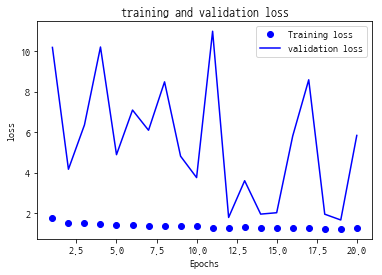

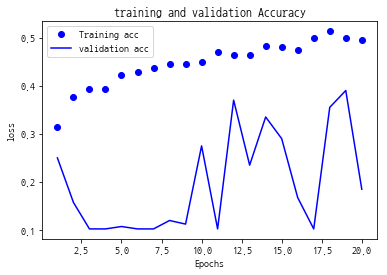

In [25]:
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.clf()

epochs = range(1, len(loss)+1)

plt.plot(epochs, loss, 'bo', label = 'Training loss')
plt.plot(epochs, val_loss, 'b', label = 'validation loss')
plt.title('training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

plt.clf()
acc= history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label = 'validation acc')
plt.title('training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.legend()
plt.show()